In [1]:
#Load libraries

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
#print('done')

In [2]:
#Load credit card default dataset
df = pd.read_excel('D:/SDU/thesisCodes/data/default of credit card clients.xls')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
#Create X, Y, train and test datasets
X = df.drop(['default payment next month','ID'], axis = 1)
Y = df['default payment next month']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

In [4]:
#Build the random forest classifier
rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)

yPredRf = rf.predict(X_test)
print(metrics.classification_report(Y_test, yPredRf))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5873
           1       0.66      0.30      0.42      1627

    accuracy                           0.81      7500
   macro avg       0.74      0.63      0.65      7500
weighted avg       0.79      0.81      0.79      7500



Text(0, 0.5, 'Cross-validated accuracy')

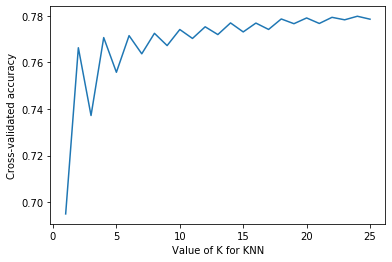

In [5]:
#Start KNN implementation. Do elbow method to define number of K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Number of k from 1 to 26
k_range = range(1, 26)
k_scores = []
# Calculate cross validation score for every k number from 1 to 26
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # It’s 10 fold cross validation with ‘accuracy’ scoring 
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())
    
%matplotlib inline
# Plot accuracy for every k number between 1 and 26
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [6]:
# Train the KNN model and use k=17 based on above graph
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, Y_train)
yPredKNN = knn.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredKNN))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      5873
           1       0.44      0.11      0.18      1627

    accuracy                           0.78      7500
   macro avg       0.62      0.54      0.52      7500
weighted avg       0.72      0.78      0.72      7500



In [7]:
#Train the GNB model

gnb=GaussianNB()
gnb.fit(X_train,Y_train)

yPredGNB = gnb.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredGNB))

              precision    recall  f1-score   support

           0       0.88      0.24      0.38      5873
           1       0.24      0.89      0.38      1627

    accuracy                           0.38      7500
   macro avg       0.56      0.56      0.38      7500
weighted avg       0.75      0.38      0.38      7500



In [8]:
#Train the XGB model

xgbModel = xgb.XGBClassifier(random_state=1)
xgbModel.fit(X_train, Y_train)
yPredXGB = xgbModel.predict(X_test)
print(metrics.classification_report(Y_test, yPredXGB))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5873
           1       0.62      0.36      0.46      1627

    accuracy                           0.81      7500
   macro avg       0.73      0.65      0.67      7500
weighted avg       0.79      0.81      0.79      7500



In [9]:
#Start Manifold implementation

#Prepare Y_test for Manifold
Y_testMf = Y_test.to_frame()
Y_testMf = Y_testMf.replace(0, 'False')
Y_testMf = Y_testMf.replace(1, 'True')
Y_testMf = Y_testMf.values.tolist()

Y_testMfFlat = []
for sublist in Y_testMf:
    for item in sublist:
        Y_testMfFlat.append(item)

In [10]:
#Prepare RF dataset for Manifold
yPredRFpp = rf.predict_proba(X_test)

yPredRFpp0 = yPredRFpp[:,0]
yPredRFpp1 = yPredRFpp[:,1]

yPredRFpp0 = yPredRFpp0.tolist()
yPredRFpp1 = yPredRFpp1.tolist()

yPredRFppFinal = [{'True': f, 'False': c} for f, c in zip(yPredRFpp1, yPredRFpp0)]


#Prepare GNB dataset for Manifold
yPredGNBpp = gnb.predict_proba(X_test)

yPredGNBpp0 = yPredGNBpp[:,0]
yPredGNBpp1 = yPredGNBpp[:,1]

yPredGNBpp0 = yPredGNBpp0.tolist()
yPredGNBpp1 = yPredGNBpp1.tolist()

yPredGNBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredGNBpp1, yPredGNBpp0)]


#Prepare KNN dataset for Manifold
yPredKNNpp = knn.predict_proba(X_test)

yPredKNNpp0 = yPredKNNpp[:,0]
yPredKNNpp1 = yPredKNNpp[:,1]

yPredKNNpp0 = yPredKNNpp0.tolist()
yPredKNNpp1 = yPredKNNpp1.tolist()

yPredKNNppFinal = [{'True': f, 'False': c} for f, c in zip(yPredKNNpp1, yPredKNNpp0)]


#Prepare XGB dataset for Manifold
yPredXGBpp = xgbModel.predict_proba(X_test)
yPredXGBpp = yPredXGBpp.astype(np.float64)

yPredXGBpp0 = yPredXGBpp[:,0]
yPredXGBpp1 = yPredXGBpp[:,1]

yPredXGBpp0 = yPredXGBpp0.tolist()
yPredXGBpp0 = yPredXGBpp1.tolist()

yPredXGBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredXGBpp1, yPredXGBpp0)]

In [11]:
#Insert all data into one list for passing to Manifold later

allModels = []
allModels.append(yPredGNBppFinal)
allModels.append(yPredRFppFinal)
allModels.append(yPredKNNppFinal)
allModels.append(yPredXGBppFinal)

In [12]:
#Call Manifold to get visualization
#Click export segmentation after running this cell to export the indices in desired segments

from mlvis import Manifold
Manifold(props={'data': {
    'x': X_test,
    'yPred': allModels,
    'yTrue': Y_testMfFlat
}})

Manifold(props='{"data": {"x": [{"LIMIT_BAL": 30000, "SEX": 1, "EDUCATION": 2, "MARRIAGE": 2, "AGE": 25, "PAY_…

In [14]:
#Index for segments from Manifold is exported here
segments = [[8,11,14,18,20,24,26,30,33,35,36,37,45,47,48,49,51,54,55,56,57,59,64,65,74,76,78,80,82,83,84,87,94,101,103,108,109,110,118,119,120,122,128,130,131,134,136,139,140,141,142,143,151,153,160,164,169,171,173,177,183,186,187,194,197,200,202,203,205,206,210,211,219,221,222,223,228,230,235,236,237,241,246,251,252,255,256,259,261,262,263,267,268,271,276,278,282,283,293,295,299,307,308,309,321,322,323,326,337,338,341,342,348,356,371,375,376,377,378,379,384,386,389,390,393,395,397,404,408,409,412,414,416,417,422,424,426,431,435,438,442,443,446,447,449,451,454,456,462,469,472,476,478,481,482,489,493,504,509,512,516,517,518,519,520,523,527,529,530,532,534,536,538,542,547,549,550,554,559,561,563,564,567,569,575,580,582,583,584,585,587,591,594,595,600,611,612,614,619,620,622,627,630,631,633,642,644,645,646,651,654,656,659,660,669,673,675,677,678,684,685,686,687,690,698,699,703,705,710,711,712,724,725,730,737,740,747,756,761,764,769,773,774,777,778,779,780,781,782,788,791,794,795,800,803,804,805,806,807,808,809,810,812,813,815,817,820,822,823,828,833,835,838,840,849,858,860,861,867,878,882,884,885,887,888,889,890,891,896,901,906,909,912,915,916,917,922,924,925,932,938,939,941,945,950,952,955,956,957,959,960,964,965,967,970,973,986,988,989,990,992,995,1005,1006,1009,1012,1016,1018,1019,1020,1021,1025,1026,1027,1028,1033,1034,1039,1040,1042,1044,1047,1053,1055,1056,1060,1071,1072,1073,1075,1078,1080,1081,1082,1088,1089,1095,1096,1097,1101,1102,1104,1105,1108,1111,1114,1116,1119,1120,1121,1122,1123,1124,1125,1130,1133,1135,1137,1138,1139,1140,1142,1143,1144,1145,1147,1150,1151,1155,1158,1160,1162,1163,1170,1176,1177,1179,1180,1186,1187,1189,1193,1195,1196,1200,1206,1208,1210,1214,1216,1217,1220,1224,1225,1234,1235,1236,1240,1242,1244,1249,1256,1257,1260,1263,1266,1268,1272,1274,1275,1276,1278,1279,1281,1284,1285,1289,1290,1293,1294,1296,1297,1300,1304,1312,1323,1325,1327,1329,1333,1343,1348,1349,1350,1352,1356,1357,1362,1365,1367,1374,1376,1377,1379,1380,1382,1384,1387,1388,1390,1392,1393,1399,1400,1401,1405,1407,1409,1410,1412,1413,1416,1418,1419,1435,1436,1437,1441,1443,1448,1450,1452,1454,1455,1456,1458,1462,1463,1464,1467,1470,1473,1476,1483,1486,1491,1495,1498,1499,1511,1512,1513,1516,1517,1518,1519,1520,1522,1526,1528,1529,1535,1536,1541,1545,1551,1554,1555,1562,1563,1564,1565,1567,1571,1577,1579,1581,1583,1584,1587,1589,1596,1599,1600,1601,1602,1605,1609,1610,1616,1617,1618,1622,1624,1625,1626,1628,1632,1633,1636,1637,1640,1643,1649,1652,1655,1657,1661,1664,1666,1667,1668,1669,1670,1671,1672,1673,1674,1684,1689,1690,1693,1695,1697,1699,1700,1702,1704,1706,1707,1708,1709,1710,1712,1715,1716,1717,1720,1724,1726,1727,1732,1734,1736,1739,1742,1743,1745,1749,1750,1753,1754,1758,1763,1764,1770,1771,1773,1774,1778,1779,1782,1790,1794,1795,1800,1805,1807,1808,1809,1812,1817,1818,1820,1821,1822,1827,1830,1831,1834,1838,1841,1842,1849,1852,1855,1857,1858,1865,1870,1874,1877,1881,1885,1890,1892,1893,1895,1898,1899,1900,1903,1906,1908,1911,1913,1914,1916,1918,1921,1923,1925,1928,1939,1941,1949,1950,1952,1957,1958,1963,1965,1967,1973,1981,1982,1992,1993,1997,1999,2000,2003,2004,2006,2007,2013,2016,2018,2022,2026,2031,2035,2036,2045,2050,2054,2059,2062,2064,2065,2068,2069,2070,2074,2076,2080,2088,2090,2091,2096,2101,2103,2107,2117,2118,2120,2122,2123,2127,2128,2129,2130,2134,2135,2136,2142,2149,2150,2151,2153,2154,2155,2157,2158,2165,2166,2169,2171,2173,2174,2175,2177,2180,2182,2185,2188,2189,2192,2195,2214,2220,2222,2224,2225,2230,2235,2236,2242,2243,2246,2247,2249,2254,2256,2258,2259,2266,2268,2270,2271,2274,2278,2284,2287,2288,2293,2295,2296,2303,2309,2311,2314,2317,2320,2324,2326,2327,2331,2335,2341,2342,2346,2347,2352,2357,2359,2360,2362,2366,2368,2371,2372,2374,2378,2379,2381,2384,2387,2389,2394,2396,2397,2399,2400,2401,2402,2407,2410,2412,2419,2421,2423,2426,2427,2428,2430,2436,2437,2438,2439,2444,2446,2447,2450,2451,2452,2453,2458,2467,2468,2469,2472,2474,2475,2476,2478,2479,2480,2485,2487,2490,2493,2497,2498,2502,2505,2507,2515,2517,2519,2522,2529,2530,2533,2534,2545,2546,2549,2550,2551,2558,2559,2561,2564,2566,2571,2572,2573,2575,2576,2582,2583,2586,2588,2589,2595,2597,2611,2614,2616,2617,2628,2629,2634,2640,2642,2645,2649,2650,2651,2652,2653,2659,2660,2666,2670,2671,2672,2676,2678,2680,2681,2684,2686,2692,2693,2703,2704,2708,2709,2710,2711,2715,2720,2723,2724,2726,2729,2730,2731,2737,2748,2749,2755,2756,2758,2760,2767,2769,2770,2771,2775,2777,2783,2788,2789,2793,2794,2796,2800,2805,2808,2812,2815,2818,2820,2825,2826,2827,2830,2834,2837,2845,2847,2850,2851,2852,2855,2862,2864,2868,2872,2876,2878,2882,2883,2884,2887,2890,2894,2901,2902,2903,2904,2907,2912,2915,2917,2918,2923,2924,2925,2927,2930,2932,2934,2939,2947,2948,2949,2953,2956,2957,2958,2960,2963,2965,2968,2971,2973,2974,2975,2976,2980,2983,2989,2990,2995,2998,3005,3007,3009,3011,3012,3013,3014,3015,3017,3019,3024,3025,3031,3032,3034,3035,3036,3037,3053,3055,3056,3058,3059,3064,3067,3070,3071,3072,3073,3075,3078,3079,3081,3085,3086,3087,3097,3102,3103,3104,3107,3115,3116,3118,3122,3123,3125,3126,3127,3130,3132,3133,3134,3135,3137,3139,3143,3145,3147,3152,3154,3155,3161,3163,3165,3166,3169,3170,3171,3174,3176,3177,3188,3189,3193,3195,3196,3201,3202,3205,3207,3208,3209,3212,3213,3215,3220,3224,3225,3228,3231,3232,3238,3239,3240,3244,3250,3253,3254,3257,3259,3265,3267,3268,3269,3271,3272,3273,3274,3276,3277,3280,3282,3292,3295,3297,3298,3304,3306,3307,3308,3316,3317,3318,3319,3320,3322,3323,3325,3331,3333,3335,3336,3337,3339,3340,3343,3346,3352,3353,3355,3359,3364,3381,3382,3386,3387,3388,3392,3394,3395,3398,3400,3404,3412,3414,3418,3421,3422,3424,3426,3430,3436,3453,3454,3459,3460,3466,3469,3474,3479,3481,3483,3484,3490,3491,3505,3507,3510,3511,3513,3514,3515,3516,3520,3522,3527,3529,3531,3538,3539,3541,3549,3550,3554,3556,3557,3562,3563,3565,3568,3570,3571,3572,3575,3585,3590,3592,3594,3595,3596,3598,3600,3601,3603,3605,3607,3609,3610,3612,3622,3623,3625,3632,3634,3638,3639,3640,3646,3650,3651,3654,3657,3658,3664,3667,3668,3671,3672,3679,3680,3682,3683,3686,3689,3690,3692,3694,3696,3701,3705,3706,3712,3714,3715,3716,3720,3722,3724,3727,3728,3730,3732,3737,3738,3742,3744,3745,3754,3756,3758,3761,3763,3769,3772,3776,3777,3787,3789,3791,3792,3794,3796,3800,3803,3804,3805,3812,3813,3814,3817,3818,3819,3823,3825,3827,3829,3831,3834,3835,3836,3838,3839,3842,3846,3851,3852,3857,3859,3862,3863,3864,3865,3866,3868,3869,3870,3872,3878,3882,3884,3885,3888,3889,3891,3896,3897,3899,3903,3904,3905,3907,3910,3911,3912,3913,3915,3921,3924,3925,3927,3931,3933,3936,3937,3943,3946,3948,3953,3957,3962,3965,3974,3975,3977,3979,3980,3981,3983,3984,3989,3990,3997,4000,4004,4005,4006,4007,4008,4012,4014,4017,4019,4023,4025,4030,4031,4033,4034,4038,4039,4046,4048,4050,4052,4054,4055,4059,4060,4067,4072,4076,4078,4083,4087,4089,4092,4093,4094,4096,4097,4101,4104,4109,4110,4111,4112,4115,4116,4118,4119,4123,4124,4126,4131,4133,4135,4137,4147,4148,4151,4153,4156,4157,4160,4162,4165,4167,4171,4175,4176,4180,4181,4183,4184,4185,4188,4189,4191,4193,4195,4198,4199,4202,4213,4217,4221,4223,4225,4226,4228,4229,4233,4236,4237,4239,4241,4245,4247,4249,4251,4254,4257,4259,4264,4267,4273,4275,4278,4279,4281,4285,4287,4289,4293,4295,4296,4300,4301,4307,4308,4309,4311,4314,4316,4320,4321,4322,4324,4326,4332,4335,4343,4346,4348,4351,4362,4365,4370,4372,4373,4389,4397,4405,4407,4408,4417,4418,4420,4421,4426,4427,4428,4430,4433,4435,4440,4442,4447,4450,4452,4453,4455,4458,4464,4465,4466,4467,4469,4470,4471,4484,4492,4495,4497,4499,4502,4507,4508,4510,4512,4514,4517,4518,4519,4522,4531,4533,4535,4537,4538,4539,4544,4545,4546,4551,4554,4559,4561,4562,4564,4570,4571,4573,4575,4578,4584,4586,4587,4589,4592,4593,4594,4599,4603,4604,4605,4606,4608,4614,4617,4630,4640,4643,4648,4652,4653,4655,4662,4666,4667,4669,4672,4673,4675,4676,4678,4682,4683,4687,4689,4690,4691,4692,4693,4694,4695,4701,4704,4705,4706,4708,4714,4719,4722,4734,4736,4738,4742,4744,4746,4749,4753,4758,4762,4766,4768,4771,4773,4780,4785,4787,4789,4793,4801,4803,4804,4808,4811,4812,4817,4819,4824,4826,4830,4832,4834,4835,4836,4838,4839,4841,4843,4851,4852,4854,4857,4858,4861,4864,4865,4866,4877,4880,4884,4885,4887,4889,4890,4893,4899,4900,4901,4903,4906,4907,4910,4912,4913,4914,4915,4916,4919,4924,4926,4927,4930,4931,4936,4937,4938,4940,4944,4954,4959,4962,4966,4967,4968,4973,4974,4977,4983,4988,4990,4995,4997,5002,5003,5004,5006,5008,5010,5012,5015,5016,5019,5023,5024,5036,5038,5040,5043,5049,5050,5051,5053,5054,5056,5060,5062,5067,5073,5081,5082,5084,5086,5094,5095,5101,5102,5106,5108,5109,5110,5112,5113,5115,5116,5117,5121,5127,5132,5133,5137,5138,5142,5143,5151,5153,5154,5157,5162,5166,5167,5168,5175,5177,5178,5181,5183,5184,5189,5192,5193,5201,5204,5205,5206,5208,5212,5214,5215,5217,5218,5219,5221,5224,5227,5228,5231,5233,5240,5242,5244,5245,5246,5248,5250,5254,5255,5262,5267,5269,5270,5277,5278,5279,5280,5282,5284,5285,5287,5292,5294,5295,5301,5305,5306,5307,5311,5312,5316,5323,5324,5327,5331,5332,5333,5335,5337,5341,5342,5343,5344,5351,5352,5355,5358,5360,5361,5362,5364,5369,5372,5376,5383,5384,5387,5390,5391,5392,5408,5409,5410,5411,5412,5419,5421,5423,5425,5433,5435,5436,5437,5440,5441,5443,5444,5446,5449,5451,5452,5453,5454,5458,5460,5461,5464,5466,5467,5472,5475,5476,5480,5482,5483,5488,5489,5490,5491,5492,5493,5494,5497,5498,5502,5504,5507,5509,5514,5516,5518,5521,5526,5527,5533,5538,5540,5545,5550,5555,5557,5560,5561,5562,5564,5566,5567,5573,5574,5575,5579,5587,5588,5591,5598,5600,5603,5605,5606,5608,5611,5612,5622,5625,5626,5627,5628,5635,5636,5647,5648,5664,5665,5667,5671,5673,5674,5680,5681,5685,5689,5691,5692,5693,5694,5701,5703,5708,5718,5721,5724,5727,5728,5732,5734,5735,5738,5740,5745,5751,5752,5753,5754,5756,5759,5765,5772,5775,5778,5779,5780,5783,5785,5787,5792,5794,5796,5798,5802,5804,5806,5810,5813,5818,5821,5822,5826,5827,5828,5830,5831,5836,5840,5841,5842,5843,5846,5847,5848,5850,5854,5858,5862,5864,5873,5878,5880,5884,5891,5894,5899,5902,5904,5906,5910,5911,5912,5917,5918,5921,5922,5928,5931,5933,5936,5938,5939,5940,5944,5948,5949,5953,5960,5965,5968,5970,5971,5980,5981,5984,5985,5986,5987,5989,5991,5999,6002,6007,6009,6015,6017,6018,6021,6027,6031,6032,6033,6037,6039,6042,6050,6058,6062,6063,6065,6066,6067,6069,6072,6076,6077,6083,6091,6092,6093,6098,6099,6100,6102,6105,6106,6107,6110,6111,6112,6113,6123,6127,6142,6143,6146,6150,6154,6160,6161,6162,6166,6169,6171,6172,6173,6174,6177,6180,6183,6187,6188,6190,6194,6195,6204,6206,6209,6210,6211,6212,6215,6216,6218,6219,6223,6229,6232,6234,6235,6242,6243,6245,6250,6251,6252,6257,6258,6261,6266,6270,6272,6280,6282,6291,6293,6296,6298,6300,6305,6307,6309,6319,6320,6321,6323,6325,6334,6335,6341,6342,6344,6346,6347,6349,6350,6354,6356,6360,6363,6365,6371,6377,6381,6382,6391,6392,6396,6399,6400,6401,6404,6405,6414,6416,6417,6421,6422,6424,6433,6434,6436,6442,6447,6451,6455,6459,6461,6465,6469,6470,6471,6478,6479,6485,6486,6488,6489,6490,6495,6502,6506,6507,6508,6509,6512,6513,6517,6519,6520,6522,6524,6527,6528,6529,6531,6535,6536,6538,6539,6540,6542,6543,6545,6547,6548,6549,6552,6554,6555,6561,6564,6565,6567,6569,6570,6576,6584,6590,6591,6592,6594,6596,6602,6603,6606,6608,6610,6611,6618,6626,6627,6628,6630,6632,6636,6639,6641,6642,6643,6646,6648,6654,6659,6660,6661,6667,6668,6670,6672,6673,6674,6677,6678,6679,6680,6683,6684,6685,6694,6695,6696,6700,6707,6713,6714,6717,6718,6720,6727,6728,6729,6730,6733,6736,6737,6741,6751,6753,6755,6759,6760,6763,6765,6767,6769,6771,6772,6774,6775,6776,6777,6793,6794,6799,6800,6803,6808,6813,6817,6820,6823,6829,6832,6834,6838,6841,6843,6844,6847,6848,6857,6862,6865,6872,6874,6875,6877,6882,6883,6887,6891,6892,6893,6896,6898,6899,6901,6903,6907,6908,6911,6914,6916,6927,6953,6954,6957,6960,6972,6973,6978,6987,6989,6994,6995,6997,6998,7001,7004,7007,7009,7011,7013,7015,7016,7020,7025,7027,7034,7047,7049,7055,7059,7062,7065,7067,7069,7071,7073,7077,7079,7080,7081,7082,7084,7090,7091,7094,7096,7097,7098,7102,7103,7118,7119,7121,7122,7123,7125,7127,7129,7131,7132,7133,7146,7147,7149,7151,7158,7159,7161,7166,7176,7180,7181,7183,7187,7188,7189,7195,7196,7197,7198,7204,7212,7215,7220,7227,7228,7234,7239,7241,7242,7244,7247,7250,7251,7260,7263,7265,7267,7268,7269,7270,7273,7274,7275,7276,7283,7284,7285,7289,7291,7294,7295,7296,7297,7298,7302,7304,7305,7309,7313,7315,7318,7319,7321,7330,7332,7333,7338,7343,7347,7354,7361,7363,7365,7374,7376,7377,7380,7385,7389,7392,7395,7396,7400,7404,7405,7406,7408,7409,7420,7424,7425,7428,7429,7435,7439,7442,7444,7454,7455,7457,7463,7468,7470,7472,7473,7474,7478,7485,7491,7496,0,1,2,3,5,7,9,10,12,15,16,17,22,23,25,28,29,32,39,40,43,52,53,58,61,62,63,66,67,69,70,73,79,81,85,88,89,95,97,98,100,102,105,106,111,112,115,116,117,123,126,127,129,133,135,137,148,149,150,154,155,157,158,159,161,162,163,165,167,168,172,174,175,176,178,179,181,188,189,190,192,198,199,201,204,207,208,209,212,213,218,220,225,226,229,233,238,239,240,242,243,245,248,249,250,253,254,257,258,264,265,266,269,270,272,274,279,286,289,292,298,300,301,302,304,306,312,313,316,317,318,319,320,324,328,329,332,333,335,336,339,340,343,344,346,349,350,351,352,354,355,360,363,366,368,369,373,374,380,382,383,385,387,388,391,398,400,401,402,405,406,419,420,421,423,425,427,428,429,430,433,439,440,444,445,448,450,452,455,458,459,460,461,463,465,468,470,473,475,477,487,488,494,495,496,499,500,501,502,503,505,506,507,508,511,513,515,521,522,524,525,528,531,533,535,539,540,541,543,544,545,546,548,551,552,553,555,556,560,562,566,568,570,572,573,574,577,579,581,586,588,593,598,599,604,605,607,609,610,613,615,617,618,621,623,624,629,635,636,637,638,639,640,641,643,647,648,649,650,652,653,655,658,661,663,665,666,667,668,671,672,674,676,679,681,683,688,691,692,694,695,696,697,700,702,704,707,709,713,714,715,717,720,721,726,727,728,729,732,733,734,736,739,742,744,745,746,748,752,753,755,759,762,763,765,766,767,768,770,771,772,783,784,786,790,792,796,797,799,802,814,816,819,821,825,829,831,832,834,836,841,842,843,844,845,851,853,855,856,857,863,864,866,869,871,872,873,874,875,877,879,880,883,886,893,894,897,898,900,904,908,910,911,920,921,926,927,928,929,930,933,934,936,937,940,942,943,944,946,947,948,951,958,961,962,968,969,972,974,978,980,981,982,983,984,993,994,996,998,1001,1002,1008,1010,1011,1013,1014,1015,1023,1029,1032,1036,1037,1041,1045,1049,1050,1052,1054,1057,1062,1063,1065,1066,1067,1068,1069,1076,1079,1084,1086,1087,1090,1091,1094,1098,1099,1103,1106,1107,1109,1112,1113,1115,1117,1118,1126,1127,1128,1129,1132,1134,1136,1141,1146,1148,1149,1156,1157,1161,1164,1165,1166,1167,1172,1178,1181,1182,1184,1185,1188,1190,1191,1194,1197,1199,1201,1203,1204,1211,1212,1215,1218,1219,1223,1227,1229,1230,1232,1233,1238,1241,1243,1245,1246,1248,1250,1252,1254,1255,1261,1262,1264,1267,1269,1270,1271,1273,1277,1280,1282,1286,1287,1288,1295,1298,1301,1302,1306,1310,1314,1315,1317,1319,1322,1328,1331,1334,1335,1336,1337,1338,1339,1341,1344,1347,1353,1354,1355,1359,1360,1361,1363,1364,1366,1368,1370,1371,1372,1373,1378,1381,1383,1385,1391,1394,1396,1397,1398,1404,1406,1408,1411,1415,1417,1420,1422,1423,1427,1428,1430,1432,1433,1434,1438,1439,1442,1445,1446,1447,1453,1459,1460,1461,1466,1468,1469,1471,1474,1477,1478,1481,1482,1484,1487,1488,1489,1490,1493,1494,1497,1500,1501,1504,1506,1507,1509,1514,1515,1521,1524,1527,1531,1532,1533,1534,1537,1538,1540,1542,1543,1544,1546,1547,1548,1550,1552,1553,1556,1557,1558,1560,1566,1569,1570,1572,1573,1574,1575,1578,1580,1585,1586,1588,1590,1591,1595,1597,1598,1606,1607,1608,1611,1612,1614,1615,1623,1627,1629,1630,1631,1634,1638,1639,1641,1642,1644,1645,1646,1648,1650,1651,1654,1658,1659,1660,1662,1663,1675,1677,1679,1680,1681,1682,1685,1686,1687,1694,1696,1698,1701,1705,1711,1714,1718,1721,1722,1723,1725,1729,1730,1731,1733,1735,1738,1740,1741,1746,1747,1748,1751,1756,1757,1759,1760,1761,1762,1765,1766,1767,1768,1769,1772,1775,1776,1777,1780,1781,1783,1784,1787,1788,1792,1793,1797,1798,1799,1801,1810,1813,1814,1815,1823,1824,1825,1828,1833,1835,1836,1840,1843,1844,1847,1848,1850,1853,1854,1856,1859,1860,1861,1862,1863,1867,1868,1869,1871,1872,1875,1876,1878,1882,1884,1891,1896,1897,1901,1902,1904,1907,1910,1912,1915,1917,1919,1926,1927,1929,1930,1931,1932,1934,1935,1936,1937,1938,1943,1944,1947,1948,1951,1954,1956,1961,1964,1966,1968,1970,1971,1972,1974,1976,1977,1978,1983,1984,1985,1986,1987,1989,1994,1996,1998,2001,2002,2005,2010,2011,2014,2015,2017,2019,2020,2021,2023,2027,2028,2029,2030,2032,2033,2038,2039,2041,2042,2044,2046,2047,2048,2051,2053,2055,2057,2061,2063,2067,2071,2073,2075,2077,2079,2081,2083,2084,2085,2087,2089,2092,2094,2097,2098,2099,2104,2105,2106,2108,2109,2111,2112,2114,2115,2119,2121,2124,2125,2131,2132,2133,2137,2140,2145,2147,2156,2159,2161,2163,2164,2167,2170,2178,2181,2183,2186,2187,2190,2194,2196,2197,2198,2199,2200,2202,2204,2205,2206,2207,2208,2209,2210,2212,2213,2215,2216,2217,2218,2219,2221,2223,2226,2228,2229,2231,2232,2233,2234,2237,2238,2239,2245,2250,2251,2252,2253,2257,2260,2261,2265,2269,2273,2277,2279,2282,2283,2285,2286,2290,2292,2294,2297,2298,2299,2304,2305,2306,2307,2308,2313,2315,2318,2319,2322,2325,2328,2329,2330,2332,2334,2338,2343,2344,2345,2348,2349,2350,2351,2353,2355,2356,2364,2365,2369,2370,2375,2376,2377,2380,2382,2383,2386,2390,2392,2403,2405,2411,2416,2417,2420,2424,2431,2432,2433,2435,2441,2443,2445,2454,2456,2457,2459,2460,2462,2463,2465,2466,2470,2471,2482,2484,2488,2489,2491,2492,2494,2495,2496,2499,2500,2501,2504,2506,2509,2510,2512,2513,2516,2518,2523,2525,2526,2527,2528,2531,2532,2535,2536,2537,2538,2540,2541,2542,2543,2544,2547,2548,2552,2553,2554,2560,2562,2563,2569,2570,2574,2579,2580,2585,2590,2591,2592,2593,2594,2596,2600,2601,2603,2604,2607,2608,2618,2620,2621,2623,2624,2626,2632,2633,2635,2636,2643,2644,2646,2647,2654,2655,2658,2661,2663,2665,2674,2677,2679,2682,2685,2688,2690,2691,2694,2696,2697,2698,2699,2712,2714,2717,2718,2719,2721,2722,2725,2732,2733,2734,2735,2736,2738,2739,2740,2742,2743,2745,2750,2751,2752,2753,2754,2757,2759,2761,2763,2765,2766,2768,2772,2774,2776,2781,2782,2785,2786,2790,2795,2797,2798,2799,2802,2806,2807,2809,2810,2813,2817,2821,2822,2823,2828,2829,2831,2832,2833,2835,2836,2838,2839,2842,2843,2844,2846,2848,2849,2853,2854,2857,2858,2860,2866,2867,2869,2870,2873,2874,2875,2877,2879,2880,2881,2885,2886,2889,2895,2897,2898,2906,2909,2911,2913,2914,2920,2921,2926,2928,2933,2936,2937,2938,2940,2941,2944,2946,2954,2955,2961,2966,2969,2970,2977,2979,2981,2984,2985,2991,2992,2993,2994,2996,2997,2999,3000,3001,3003,3004,3008,3010,3018,3021,3022,3026,3028,3030,3033,3041,3042,3044,3046,3047,3048,3049,3050,3052,3054,3057,3066,3080,3088,3089,3092,3098,3099,3100,3105,3108,3109,3113,3114,3117,3119,3120,3128,3131,3138,3141,3142,3144,3146,3148,3149,3151,3153,3159,3164,3168,3173,3175,3178,3179,3180,3181,3186,3187,3191,3194,3197,3198,3199,3200,3203,3204,3206,3210,3211,3214,3219,3221,3222,3223,3227,3230,3234,3235,3236,3237,3241,3243,3245,3247,3248,3249,3251,3252,3256,3258,3263,3264,3270,3275,3279,3283,3285,3286,3287,3288,3293,3294,3299,3300,3302,3309,3310,3314,3315,3321,3327,3330,3334,3338,3341,3342,3344,3345,3348,3350,3354,3357,3360,3361,3362,3363,3365,3368,3369,3371,3376,3378,3379,3380,3383,3384,3391,3393,3396,3397,3399,3401,3403,3405,3406,3407,3408,3409,3410,3413,3415,3417,3419,3420,3425,3427,3432,3437,3438,3439,3440,3441,3442,3444,3446,3447,3449,3455,3456,3457,3458,3462,3463,3465,3471,3473,3475,3476,3478,3480,3482,3485,3486,3488,3489,3493,3494,3496,3497,3498,3499,3500,3501,3502,3503,3504,3509,3512,3517,3519,3523,3524,3526,3528,3530,3532,3533,3534,3536,3542,3543,3545,3546,3548,3551,3552,3553,3558,3559,3560,3566,3567,3573,3574,3576,3577,3578,3579,3580,3581,3582,3584,3587,3588,3589,3591,3593,3604,3611,3613,3614,3616,3617,3619,3621,3624,3627,3629,3630,3631,3633,3636,3641,3644,3645,3647,3649,3652,3653,3655,3656,3659,3661,3662,3669,3674,3675,3676,3677,3678,3681,3685,3688,3693,3695,3699,3700,3704,3709,3710,3711,3713,3723,3725,3726,3729,3731,3733,3735,3740,3746,3747,3748,3750,3752,3753,3757,3760,3762,3764,3766,3767,3768,3770,3771,3773,3774,3775,3778,3780,3782,3783,3785,3786,3788,3797,3798,3799,3806,3808,3809,3810,3816,3820,3826,3828,3830,3832,3833,3837,3840,3843,3844,3845,3848,3849,3850,3853,3855,3856,3858,3860,3861,3867,3871,3874,3875,3879,3881,3886,3890,3892,3893,3894,3895,3900,3901,3902,3908,3909,3914,3916,3917,3918,3919,3920,3922,3923,3928,3929,3930,3935,3940,3945,3947,3950,3951,3954,3955,3956,3959,3961,3964,3967,3968,3969,3971,3972,3973,3976,3978,3985,3986,3987,3991,3992,3994,3995,3996,3998,4001,4002,4003,4013,4016,4020,4021,4022,4024,4026,4028,4029,4032,4041,4045,4047,4049,4051,4057,4058,4062,4063,4065,4068,4069,4073,4077,4079,4080,4081,4082,4084,4086,4088,4090,4095,4098,4100,4107,4108,4113,4120,4121,4122,4125,4128,4129,4130,4132,4136,4139,4140,4141,4143,4144,4146,4149,4150,4152,4155,4158,4159,4163,4164,4166,4169,4170,4172,4177,4179,4182,4186,4190,4196,4197,4200,4203,4204,4206,4207,4210,4211,4214,4216,4218,4219,4220,4224,4227,4231,4232,4234,4235,4240,4242,4246,4255,4256,4258,4260,4262,4265,4269,4270,4272,4274,4276,4280,4283,4284,4286,4288,4291,4294,4297,4302,4303,4304,4306,4310,4313,4317,4319,4323,4329,4330,4331,4333,4334,4336,4337,4339,4340,4341,4342,4344,4347,4349,4350,4353,4354,4355,4356,4357,4358,4361,4363,4366,4368,4369,4371,4374,4375,4378,4379,4380,4383,4388,4390,4391,4392,4394,4395,4398,4401,4402,4403,4411,4412,4414,4416,4422,4423,4424,4425,4429,4431,4432,4434,4436,4438,4443,4446,4448,4451,4454,4457,4474,4475,4476,4477,4483,4485,4486,4487,4488,4489,4490,4491,4493,4494,4496,4500,4501,4503,4505,4506,4509,4511,4513,4515,4521,4523,4524,4528,4529,4532,4534,4536,4540,4543,4547,4549,4550,4552,4553,4556,4557,4558,4563,4565,4566,4567,4568,4569,4572,4577,4579,4580,4582,4590,4591,4595,4596,4598,4600,4602,4610,4611,4612,4613,4615,4616,4618,4620,4621,4625,4627,4629,4634,4635,4636,4637,4639,4646,4647,4650,4657,4658,4659,4665,4668,4671,4674,4677,4684,4686,4688,4698,4700,4702,4703,4709,4710,4718,4720,4721,4723,4724,4726,4727,4728,4732,4733,4740,4741,4743,4745,4747,4748,4750,4752,4754,4756,4760,4761,4763,4765,4769,4772,4774,4776,4778,4779,4782,4784,4786,4790,4791,4794,4795,4796,4797,4798,4799,4800,4805,4806,4810,4813,4814,4816,4818,4820,4822,4825,4827,4828,4829,4831,4837,4842,4846,4847,4848,4849,4850,4855,4856,4859,4860,4862,4867,4869,4871,4875,4878,4879,4881,4891,4892,4894,4895,4896,4897,4902,4905,4908,4918,4920,4922,4923,4934,4941,4943,4946,4947,4948,4950,4951,4952,4953,4956,4958,4961,4963,4964,4965,4970,4972,4975,4976,4978,4979,4984,4985,4986,4989,4991,4992,4994,4996,4998,4999,5000,5013,5018,5020,5021,5022,5027,5029,5030,5031,5033,5034,5037,5039,5041,5045,5046,5047,5048,5052,5057,5059,5063,5065,5066,5071,5075,5077,5078,5080,5083,5088,5089,5090,5091,5093,5096,5097,5098,5099,5105,5111,5114,5118,5119,5122,5123,5124,5125,5128,5130,5135,5139,5144,5146,5147,5148,5149,5150,5155,5159,5161,5163,5165,5169,5170,5171,5172,5173,5179,5180,5182,5185,5187,5188,5194,5195,5196,5197,5202,5207,5209,5210,5211,5213,5220,5223,5229,5232,5235,5237,5239,5241,5243,5247,5252,5253,5257,5259,5260,5261,5263,5264,5266,5271,5272,5273,5274,5276,5281,5283,5286,5288,5291,5297,5298,5299,5300,5302,5304,5308,5309,5310,5313,5315,5317,5318,5320,5321,5322,5329,5330,5336,5339,5340,5345,5346,5350,5353,5356,5359,5363,5367,5370,5371,5373,5377,5378,5381,5382,5385,5386,5388,5389,5393,5395,5396,5400,5402,5403,5404,5406,5413,5414,5415,5416,5417,5418,5422,5424,5428,5429,5430,5431,5439,5442,5445,5447,5448,5450,5455,5456,5457,5462,5463,5468,5469,5470,5471,5473,5474,5477,5484,5496,5500,5501,5503,5506,5508,5510,5512,5515,5517,5519,5520,5524,5525,5528,5529,5530,5532,5534,5535,5536,5537,5539,5542,5543,5546,5548,5549,5552,5556,5558,5559,5563,5565,5568,5570,5571,5572,5576,5577,5578,5581,5582,5583,5584,5585,5586,5589,5590,5592,5594,5595,5596,5599,5602,5604,5607,5609,5610,5613,5616,5618,5619,5620,5623,5624,5629,5632,5634,5637,5639,5640,5641,5642,5643,5645,5649,5650,5651,5652,5653,5654,5656,5657,5659,5661,5662,5669,5670,5672,5675,5676,5677,5682,5683,5684,5686,5687,5690,5695,5696,5698,5700,5706,5707,5710,5711,5712,5713,5714,5715,5717,5719,5720,5722,5726,5729,5731,5733,5736,5737,5742,5743,5744,5747,5748,5749,5750,5755,5758,5761,5764,5767,5769,5771,5773,5774,5777,5782,5784,5788,5789,5790,5791,5793,5797,5801,5803,5805,5807,5808,5809,5811,5814,5815,5817,5819,5825,5833,5834,5837,5838,5839,5844,5845,5849,5853,5857,5859,5860,5861,5863,5866,5870,5872,5874,5877,5879,5886,5887,5889,5892,5893,5895,5896,5897,5900,5905,5907,5909,5913,5915,5924,5925,5926,5927,5929,5930,5932,5941,5942,5943,5946,5951,5955,5956,5959,5967,5969,5974,5975,5976,5978,5979,5982,5983,5988,5990,5992,5993,5995,5997,5998,6000,6001,6003,6004,6005,6006,6008,6011,6016,6019,6022,6023,6024,6025,6026,6028,6029,6034,6036,6038,6040,6041,6043,6044,6045,6046,6047,6051,6052,6053,6057,6059,6068,6070,6073,6074,6075,6078,6081,6082,6086,6087,6089,6090,6094,6095,6096,6097,6101,6104,6109,6116,6117,6118,6119,6120,6121,6124,6128,6129,6130,6132,6133,6134,6135,6139,6141,6144,6145,6148,6151,6152,6153,6155,6157,6158,6163,6164,6165,6167,6175,6176,6178,6181,6189,6191,6193,6197,6198,6200,6201,6202,6205,6207,6208,6213,6214,6221,6224,6225,6226,6227,6228,6230,6231,6233,6236,6238,6239,6246,6255,6259,6262,6263,6265,6267,6268,6269,6271,6274,6276,6278,6279,6281,6284,6285,6286,6287,6289,6292,6294,6295,6297,6299,6303,6308,6312,6313,6314,6315,6316,6317,6318,6324,6326,6329,6330,6331,6332,6333,6336,6343,6345,6348,6351,6352,6353,6355,6357,6359,6361,6362,6366,6368,6369,6372,6373,6375,6378,6379,6380,6383,6384,6385,6393,6398,6402,6403,6407,6409,6410,6411,6415,6419,6420,6423,6425,6431,6437,6438,6439,6443,6449,6450,6454,6456,6458,6460,6463,6464,6466,6467,6468,6472,6473,6474,6476,6477,6481,6493,6496,6497,6498,6500,6503,6504,6510,6514,6516,6518,6523,6530,6533,6541,6550,6551,6557,6558,6559,6562,6563,6571,6572,6573,6574,6575,6578,6579,6580,6581,6582,6583,6585,6586,6587,6588,6593,6597,6598,6601,6604,6605,6607,6609,6612,6613,6615,6616,6617,6620,6621,6624,6625,6629,6631,6633,6634,6635,6638,6645,6647,6649,6650,6652,6653,6656,6657,6658,6663,6665,6666,6675,6676,6681,6682,6686,6687,6688,6689,6690,6691,6692,6697,6698,6699,6701,6702,6704,6705,6709,6710,6711,6712,6715,6716,6719,6721,6723,6724,6725,6732,6735,6740,6742,6743,6744,6746,6747,6748,6749,6750,6752,6754,6756,6757,6761,6766,6770,6773,6781,6782,6783,6784,6785,6787,6790,6791,6796,6797,6798,6801,6802,6804,6805,6807,6810,6811,6812,6814,6815,6819,6821,6824,6825,6826,6828,6830,6831,6833,6835,6839,6842,6845,6846,6849,6852,6853,6854,6855,6856,6859,6861,6863,6867,6868,6871,6873,6876,6879,6884,6885,6886,6888,6889,6894,6895,6897,6902,6904,6905,6906,6909,6910,6912,6913,6915,6918,6919,6920,6921,6923,6924,6926,6928,6929,6930,6931,6932,6935,6936,6938,6939,6940,6941,6942,6943,6944,6946,6948,6949,6951,6952,6955,6956,6959,6963,6965,6974,6975,6976,6977,6980,6981,6982,6984,6985,6988,6990,6991,6996,7000,7006,7008,7010,7014,7018,7019,7022,7023,7024,7026,7028,7029,7031,7032,7033,7035,7036,7037,7038,7043,7044,7045,7048,7050,7053,7057,7060,7061,7063,7064,7066,7068,7070,7074,7076,7083,7085,7087,7092,7093,7095,7099,7104,7105,7106,7108,7109,7113,7114,7115,7116,7120,7124,7126,7130,7134,7135,7136,7137,7138,7140,7141,7142,7144,7145,7148,7150,7152,7154,7155,7157,7160,7162,7164,7165,7167,7168,7170,7172,7173,7175,7178,7179,7184,7186,7190,7192,7202,7205,7210,7211,7213,7214,7217,7218,7219,7221,7222,7223,7224,7226,7229,7232,7233,7236,7237,7238,7243,7245,7248,7249,7252,7253,7254,7255,7257,7259,7264,7266,7271,7277,7279,7280,7281,7282,7286,7290,7293,7300,7301,7303,7306,7307,7310,7312,7317,7323,7324,7325,7327,7329,7336,7339,7340,7341,7344,7345,7349,7350,7351,7352,7353,7355,7356,7357,7359,7362,7366,7367,7369,7370,7378,7379,7382,7383,7384,7386,7388,7391,7394,7397,7398,7402,7410,7412,7415,7416,7417,7418,7419,7421,7426,7427,7431,7434,7436,7440,7441,7443,7445,7447,7448,7449,7451,7453,7456,7460,7461,7462,7466,7467,7469,7475,7476,7477,7480,7481,7482,7483,7484,7486,7487,7488,7489,7492,7494,7495,7499],[4,6,13,19,21,27,31,34,38,41,42,44,46,50,60,68,71,72,75,77,86,90,91,92,93,96,99,104,107,113,114,121,124,125,132,138,144,145,147,152,156,166,170,180,182,184,185,191,193,195,196,214,215,216,217,224,227,231,232,234,244,247,260,273,275,277,280,281,284,285,287,288,290,291,294,296,297,303,305,310,311,314,315,325,327,330,331,334,345,347,353,357,358,359,361,362,364,365,367,370,372,381,392,394,396,399,403,407,410,411,413,415,418,432,434,437,441,457,464,466,471,474,479,483,484,485,486,490,491,492,497,498,510,514,526,537,557,558,565,571,576,578,589,590,592,596,601,602,603,606,608,616,625,626,628,632,634,657,662,664,670,680,682,689,693,701,706,708,716,718,719,722,723,731,735,738,741,743,749,750,751,754,757,758,760,775,776,785,787,789,793,798,801,811,818,824,826,827,830,837,839,846,847,848,850,852,854,859,862,865,868,870,876,881,892,895,899,902,903,905,907,913,914,918,919,923,931,935,949,953,954,963,966,971,975,976,977,979,985,987,991,997,999,1000,1004,1007,1017,1022,1024,1030,1031,1035,1038,1043,1046,1051,1058,1059,1061,1064,1070,1074,1077,1083,1085,1092,1093,1100,1110,1131,1152,1153,1154,1159,1168,1169,1171,1173,1174,1175,1183,1192,1198,1202,1205,1207,1209,1213,1221,1222,1226,1228,1231,1237,1239,1247,1251,1253,1258,1259,1265,1283,1291,1292,1299,1303,1305,1307,1308,1309,1311,1313,1316,1318,1320,1321,1324,1326,1330,1332,1340,1342,1345,1346,1351,1358,1369,1375,1386,1389,1395,1402,1403,1414,1421,1424,1425,1426,1429,1431,1440,1444,1449,1451,1457,1465,1472,1479,1480,1485,1492,1496,1502,1503,1505,1508,1510,1523,1525,1530,1539,1549,1559,1561,1576,1582,1592,1593,1594,1603,1604,1613,1619,1620,1621,1635,1647,1653,1656,1665,1676,1678,1683,1688,1691,1692,1703,1713,1719,1728,1737,1744,1752,1755,1785,1786,1789,1791,1796,1802,1803,1804,1806,1811,1816,1819,1826,1829,1832,1837,1845,1846,1864,1866,1873,1879,1880,1883,1886,1887,1888,1889,1894,1909,1922,1924,1933,1940,1942,1945,1946,1953,1955,1959,1960,1962,1969,1975,1979,1980,1988,1990,1991,1995,2008,2009,2012,2024,2025,2034,2037,2040,2043,2049,2052,2056,2058,2060,2066,2072,2078,2082,2086,2093,2095,2100,2102,2110,2113,2116,2126,2138,2139,2141,2143,2144,2146,2148,2152,2160,2162,2168,2172,2176,2179,2184,2191,2193,2201,2203,2211,2227,2240,2241,2244,2248,2255,2262,2263,2264,2267,2272,2275,2276,2280,2281,2289,2291,2300,2301,2302,2310,2312,2316,2321,2323,2333,2336,2337,2339,2340,2354,2358,2361,2363,2367,2373,2385,2388,2391,2393,2395,2398,2404,2406,2408,2409,2413,2414,2415,2418,2422,2425,2429,2434,2440,2448,2449,2455,2461,2464,2473,2477,2481,2483,2486,2503,2508,2511,2514,2520,2521,2524,2539,2555,2556,2557,2565,2567,2568,2577,2578,2581,2584,2587,2598,2599,2602,2605,2606,2609,2610,2612,2613,2615,2619,2622,2625,2627,2630,2631,2637,2638,2641,2648,2656,2657,2662,2664,2667,2668,2669,2673,2675,2683,2687,2689,2695,2700,2701,2702,2705,2706,2707,2713,2716,2727,2728,2741,2744,2746,2747,2762,2764,2773,2778,2779,2780,2784,2787,2791,2792,2801,2803,2804,2811,2814,2816,2819,2824,2840,2841,2856,2859,2861,2863,2865,2871,2888,2891,2892,2893,2896,2899,2900,2905,2908,2910,2916,2919,2922,2929,2931,2935,2942,2943,2945,2950,2951,2952,2959,2962,2964,2967,2972,2978,2982,2986,2987,2988,3002,3006,3016,3020,3023,3027,3029,3038,3039,3040,3043,3045,3051,3060,3061,3062,3063,3065,3069,3074,3076,3077,3082,3083,3084,3090,3091,3093,3094,3095,3096,3101,3106,3110,3111,3112,3121,3124,3129,3140,3150,3156,3157,3158,3160,3162,3167,3172,3182,3183,3184,3185,3190,3192,3216,3217,3218,3226,3229,3233,3242,3246,3255,3260,3261,3262,3266,3278,3281,3284,3289,3290,3296,3301,3303,3305,3311,3312,3313,3324,3326,3328,3329,3332,3347,3349,3351,3356,3358,3366,3367,3370,3372,3373,3374,3375,3377,3385,3389,3390,3402,3411,3416,3423,3428,3429,3431,3433,3434,3435,3443,3445,3448,3450,3451,3452,3461,3464,3467,3468,3470,3472,3477,3487,3492,3495,3506,3508,3518,3521,3525,3535,3540,3544,3547,3555,3561,3564,3569,3583,3586,3597,3599,3602,3606,3608,3615,3618,3620,3626,3628,3635,3637,3642,3643,3648,3660,3663,3665,3666,3670,3673,3684,3687,3691,3697,3698,3702,3703,3707,3708,3717,3718,3719,3721,3734,3736,3739,3741,3743,3749,3751,3755,3765,3779,3781,3784,3790,3793,3795,3801,3802,3807,3811,3821,3822,3824,3841,3847,3854,3873,3876,3877,3880,3883,3887,3898,3906,3926,3932,3934,3938,3939,3941,3942,3944,3949,3952,3958,3960,3963,3966,3970,3982,3988,3999,4009,4010,4011,4015,4018,4027,4035,4036,4037,4040,4042,4043,4044,4053,4056,4061,4064,4066,4070,4071,4074,4075,4085,4091,4099,4102,4103,4105,4106,4114,4117,4127,4134,4138,4142,4145,4154,4161,4168,4173,4174,4178,4187,4192,4194,4201,4205,4208,4209,4212,4215,4222,4230,4238,4243,4244,4248,4250,4252,4253,4261,4263,4266,4268,4271,4277,4282,4290,4292,4298,4305,4312,4315,4318,4325,4327,4328,4345,4352,4359,4360,4364,4367,4376,4377,4381,4382,4384,4385,4386,4387,4393,4396,4399,4400,4404,4406,4409,4410,4413,4415,4419,4437,4439,4441,4444,4456,4459,4460,4461,4462,4463,4468,4472,4473,4478,4479,4480,4481,4482,4498,4504,4516,4520,4525,4526,4527,4530,4541,4542,4548,4555,4560,4574,4576,4581,4583,4585,4588,4597,4601,4607,4609,4619,4622,4623,4624,4626,4628,4631,4632,4633,4638,4641,4642,4644,4645,4649,4651,4654,4656,4660,4661,4663,4664,4670,4679,4680,4681,4685,4697,4699,4707,4711,4712,4713,4715,4716,4717,4725,4729,4730,4731,4735,4737,4751,4755,4757,4759,4764,4767,4770,4775,4777,4781,4788,4792,4802,4807,4809,4815,4821,4823,4833,4840,4844,4845,4853,4863,4868,4870,4872,4873,4874,4876,4882,4883,4886,4888,4904,4909,4911,4917,4921,4925,4928,4929,4932,4933,4935,4939,4942,4945,4949,4955,4957,4960,4969,4980,4981,4982,4987,4993,5001,5005,5007,5009,5011,5014,5017,5025,5026,5028,5032,5035,5042,5044,5055,5058,5061,5064,5068,5069,5070,5072,5074,5076,5085,5087,5092,5100,5103,5107,5120,5126,5129,5131,5134,5136,5140,5141,5145,5152,5158,5160,5164,5174,5176,5186,5190,5191,5198,5199,5200,5203,5216,5222,5225,5226,5230,5234,5236,5238,5249,5251,5258,5265,5268,5275,5289,5290,5293,5296,5303,5314,5319,5325,5326,5328,5334,5338,5347,5348,5349,5354,5357,5365,5366,5368,5374,5375,5379,5380,5394,5397,5398,5405,5407,5420,5426,5427,5432,5434,5438,5459,5465,5478,5479,5481,5485,5486,5487,5495,5499,5505,5511,5513,5522,5523,5531,5541,5544,5547,5551,5553,5554,5569,5580,5593,5597,5601,5614,5615,5617,5621,5630,5631,5633,5638,5644,5646,5655,5658,5660,5663,5666,5668,5678,5679,5688,5697,5699,5702,5704,5705,5709,5716,5723,5725,5730,5739,5741,5746,5757,5760,5762,5763,5766,5768,5770,5776,5781,5786,5795,5799,5800,5812,5816,5820,5823,5824,5829,5832,5835,5851,5852,5855,5856,5865,5867,5868,5869,5871,5875,5876,5881,5882,5883,5885,5888,5890,5898,5901,5903,5908,5914,5919,5920,5923,5934,5935,5937,5945,5947,5950,5952,5954,5957,5958,5961,5962,5963,5964,5966,5972,5973,5977,5994,5996,6010,6012,6013,6014,6020,6030,6035,6048,6049,6054,6055,6056,6060,6061,6064,6071,6079,6080,6084,6085,6088,6103,6108,6114,6115,6122,6125,6126,6131,6136,6137,6138,6140,6147,6149,6156,6159,6168,6170,6179,6182,6184,6185,6186,6192,6196,6199,6203,6217,6220,6222,6237,6240,6241,6244,6248,6249,6253,6254,6256,6260,6264,6273,6275,6277,6283,6288,6290,6301,6302,6304,6306,6310,6311,6322,6328,6337,6338,6339,6340,6358,6364,6367,6370,6374,6376,6386,6387,6388,6389,6390,6394,6395,6397,6406,6408,6412,6413,6418,6426,6427,6428,6429,6430,6432,6435,6440,6441,6444,6445,6446,6448,6452,6453,6457,6462,6475,6480,6482,6483,6484,6487,6491,6492,6494,6499,6501,6505,6511,6515,6521,6525,6526,6532,6534,6537,6544,6546,6553,6556,6560,6566,6568,6577,6589,6595,6599,6600,6614,6619,6622,6623,6637,6640,6644,6651,6655,6662,6664,6669,6671,6693,6703,6706,6708,6722,6726,6731,6734,6738,6739,6745,6758,6762,6764,6768,6778,6779,6780,6786,6788,6789,6795,6806,6809,6816,6818,6822,6827,6836,6837,6840,6850,6851,6858,6860,6864,6866,6869,6870,6878,6880,6881,6890,6900,6917,6922,6925,6934,6937,6945,6947,6950,6958,6961,6962,6966,6967,6968,6969,6970,6971,6979,6983,6986,6992,6993,6999,7002,7003,7005,7012,7017,7021,7030,7039,7040,7041,7042,7046,7051,7054,7056,7072,7075,7078,7086,7088,7089,7100,7101,7107,7110,7111,7112,7117,7128,7139,7143,7153,7156,7163,7169,7171,7174,7177,7185,7191,7193,7194,7199,7200,7201,7203,7206,7207,7208,7209,7216,7225,7230,7231,7235,7240,7246,7256,7258,7261,7262,7272,7278,7287,7288,7292,7299,7308,7311,7314,7316,7320,7322,7326,7328,7331,7334,7335,7342,7346,7348,7358,7360,7364,7368,7371,7372,7373,7375,7381,7387,7390,7393,7399,7401,7403,7407,7411,7414,7422,7423,7430,7432,7433,7437,7438,7446,7450,7452,7458,7459,7464,7465,7471,7479,7490,7493,7497,7498,146,436,453,467,480,597,1003,1048,1475,1568,1839,1851,1905,1920,2442,2639,3068,3136,3291,3537,3759,3815,3993,4299,4338,4445,4449,4696,4739,4783,4898,4971,5079,5104,5156,5256,5399,5401,5916,6247,6327,6792,6933,6964,7052,7058,7182,7337,7413]]

In [15]:
#Create two segments of test dataset based on indices from export

X_test = X_test.reset_index(drop=True)
X_test_segment1 = X_test.loc[segments[0]]
X_test_segment2 = X_test.loc[segments[1]]

print(len(X_test_segment1))
print(len(X_test_segment2))

5729
1771


In [16]:
#Metrics for both segments

Y_test = Y_test.reset_index(drop=True)
Y_test_segment1 = Y_test.loc[segments[0]]
Y_test_segment2 = Y_test.loc[segments[1]]

yPredGNB1 = gnb.predict(X_test_segment1)
yPredGNB2 = gnb.predict(X_test_segment2)

yPredKNN1 = knn.predict(X_test_segment1)
yPredKNN2 = knn.predict(X_test_segment2)

yPredRF1 = rf.predict(X_test_segment1)
yPredRF2 = rf.predict(X_test_segment2)

yPredXGB1 = xgbModel.predict(X_test_segment1)
yPredXGB2 = xgbModel.predict(X_test_segment2)

# classification report for test set
print('GNB')
print(metrics.classification_report(Y_test_segment1, yPredGNB1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredGNB2))

print('KNN')
print(metrics.classification_report(Y_test_segment1, yPredKNN1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredKNN2))

print('RF')
print(metrics.classification_report(Y_test_segment1, yPredRF1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredRF2))

print('XGB')
print(metrics.classification_report(Y_test_segment1, yPredXGB1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredXGB2))



GNB
              precision    recall  f1-score   support

           0       0.92      0.21      0.35      5597
           1       0.00      0.17      0.01       132

    accuracy                           0.21      5729
   macro avg       0.46      0.19      0.18      5729
weighted avg       0.89      0.21      0.34      5729

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       276
           1       0.96      0.95      0.96      1495

    accuracy                           0.93      1771
   macro avg       0.85      0.87      0.86      1771
weighted avg       0.93      0.93      0.93      1771

KNN
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5597
           1       0.01      0.02      0.02       132

    accuracy                           0.94      5729
   macro avg       0.50      0.49      0.49      5729
weighted avg       0.95      0.94      0.95      5729

           

In [17]:
#Implement SHAP in respective segments. Compute summary dataset.
X_summary = shap.kmeans(X_train, 10)

#Create explainer objects
rf_explainer = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent")
knn_explainer = shap.KernelExplainer(knn.predict, X_summary)
gnb_explainer = shap.KernelExplainer(gnb.predict, X_summary)

#Update XGB model to work with SHAP
myxgbbooster = xgbModel.get_booster()    
model_bytearray = myxgbbooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
myxgbbooster.save_raw = myfun

#Create XGB explainer
xgb_explainer = shap.TreeExplainer(myxgbbooster)

In [18]:
#Compute SHAP values for segment 1
#Compute SHAP values for RF model
rf_shap_values = rf_explainer.shap_values(X_test_segment1)
print("rf")

#Compute SHAP values for KNN model
knn_shap_values = knn_explainer.shap_values(X_test_segment1, nsamples = 100,l1_reg="num_features(24)")
print("knn")

#Compute SHAP values for GNB model
gnb_shap_values = gnb_explainer.shap_values(X_test_segment1, nsamples = 100,l1_reg="num_features(24)")
print("gnb")

#Compute SHAP values for XGB model
xgb_shap_values = xgb_explainer.shap_values(X_test_segment1)
print("xgb")

rf



knn



gnb
xgb


In [19]:
#Compute SHAP values for segment 2
#Compute SHAP values for RF model
rf_shap_values2 = rf_explainer.shap_values(X_test_segment2)
print("rf")

#Compute SHAP values for KNN model
knn_shap_values2 = knn_explainer.shap_values(X_test_segment2, nsamples = 100,l1_reg="num_features(24)")
print("knn")

#Compute SHAP values for GNB model
gnb_shap_values2 = gnb_explainer.shap_values(X_test_segment2, nsamples = 100,l1_reg="num_features(24)")
print("gnb")

#Compute SHAP values for XGB model
xgb_shap_values2 = xgb_explainer.shap_values(X_test_segment2)
print("xgb")

rf



knn



gnb
xgb


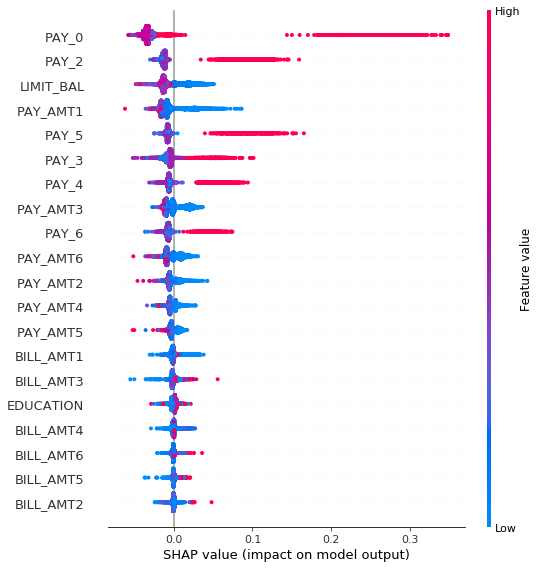

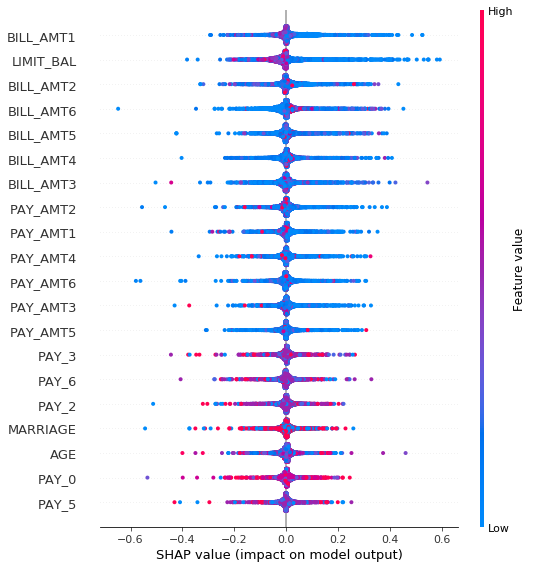

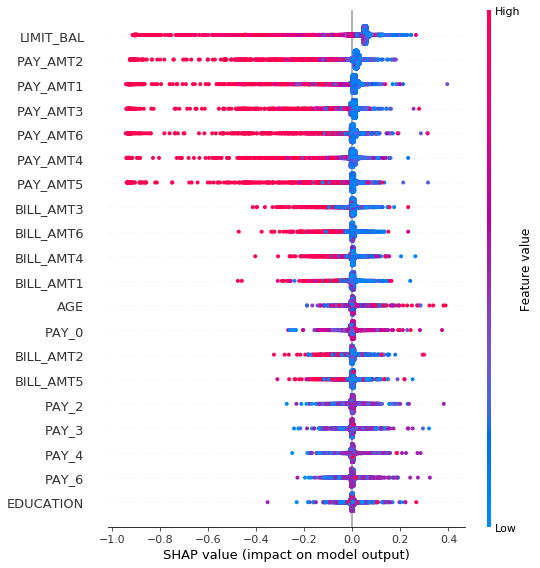

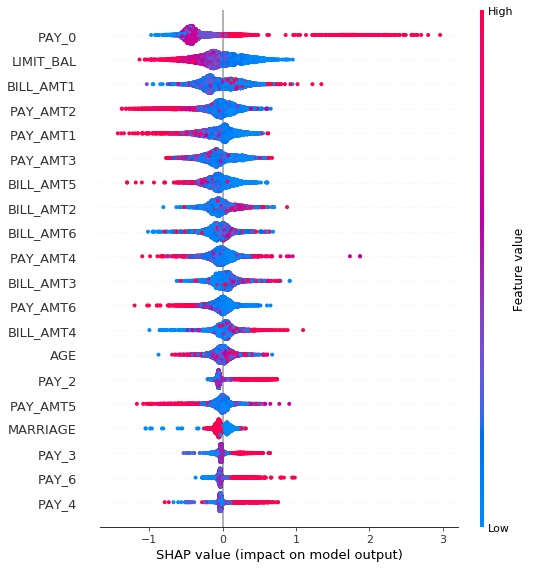

In [59]:
#Plot all the summary plots for SHAP for all models trained on segment 1

shap.summary_plot(rf_shap_values[1], X_test_segment1)
shap.summary_plot(knn_shap_values, X_test_segment1)
shap.summary_plot(gnb_shap_values, X_test_segment1)
shap.summary_plot(xgb_shap_values, X_test_segment1)

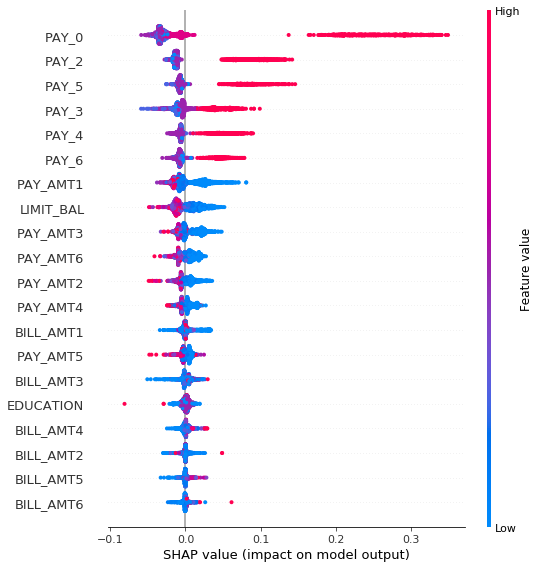

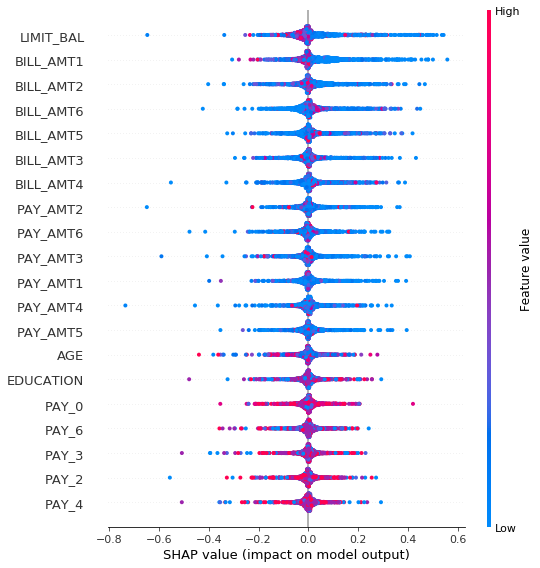

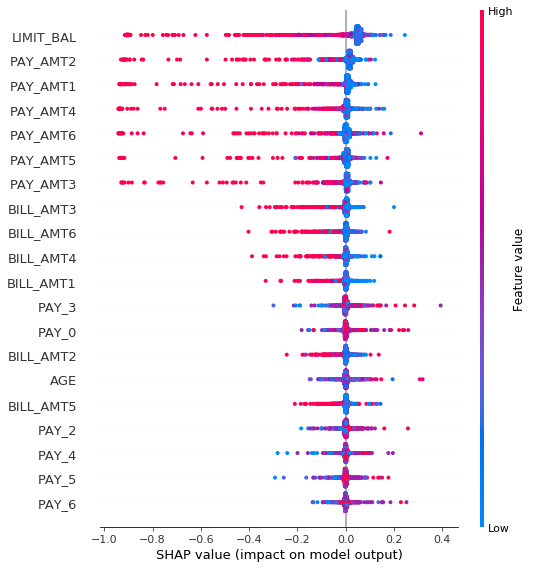

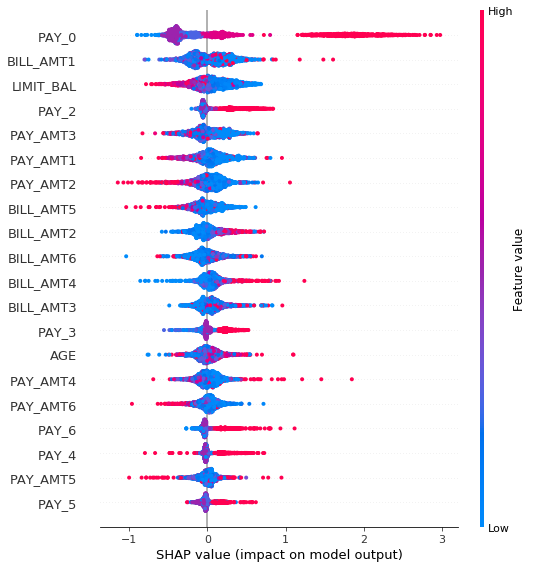

In [60]:
#Plot all the summary plots for SHAP for all models trained on segment 2

shap.summary_plot(rf_shap_values2[1], X_test_segment2)
shap.summary_plot(knn_shap_values2, X_test_segment2)
shap.summary_plot(gnb_shap_values2, X_test_segment2)
shap.summary_plot(xgb_shap_values2, X_test_segment2)

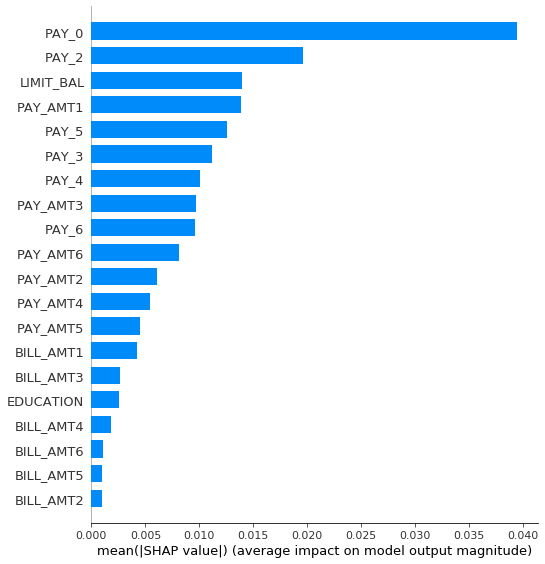

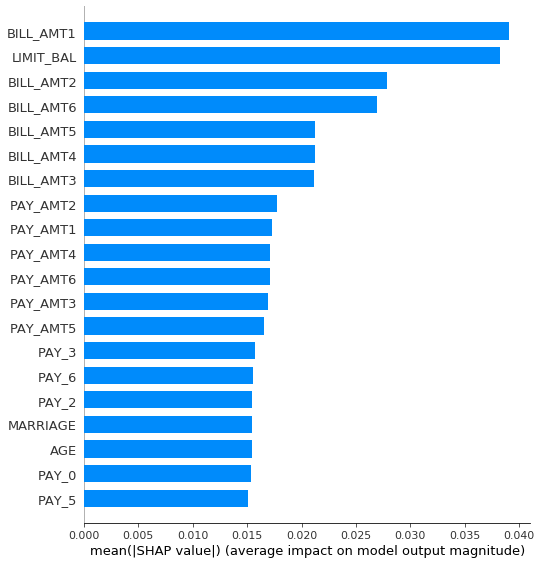

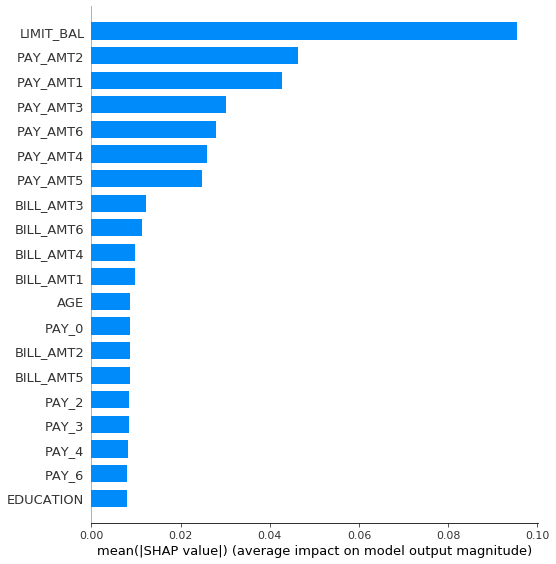

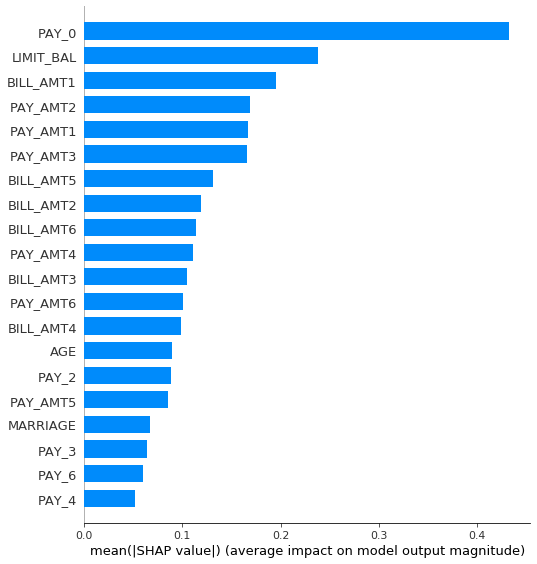

In [53]:
#Plot all the summary bar plots for SHAP for all models trained on segment 1

shap.summary_plot(rf_shap_values[1], X_test_segment1, plot_type='bar')
shap.summary_plot(knn_shap_values, X_test_segment1, plot_type='bar')
shap.summary_plot(gnb_shap_values, X_test_segment1, plot_type='bar')
shap.summary_plot(xgb_shap_values, X_test_segment1, plot_type='bar')

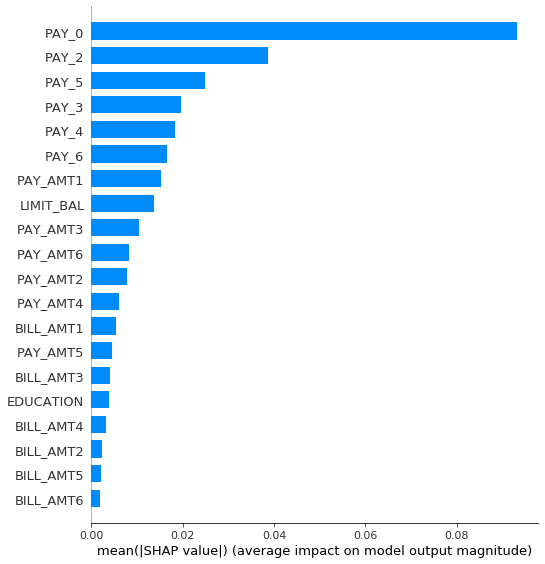

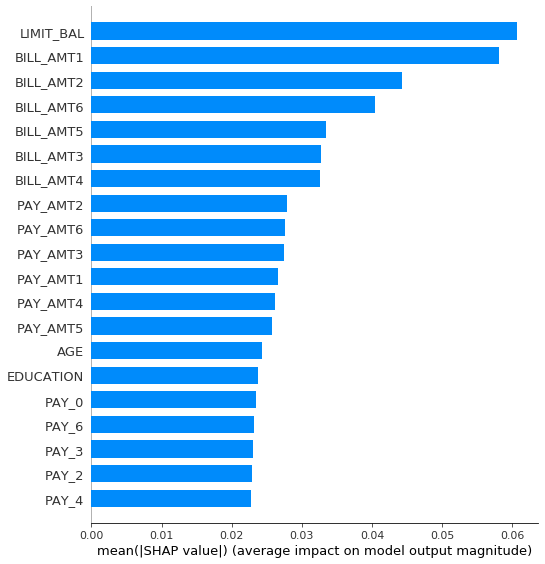

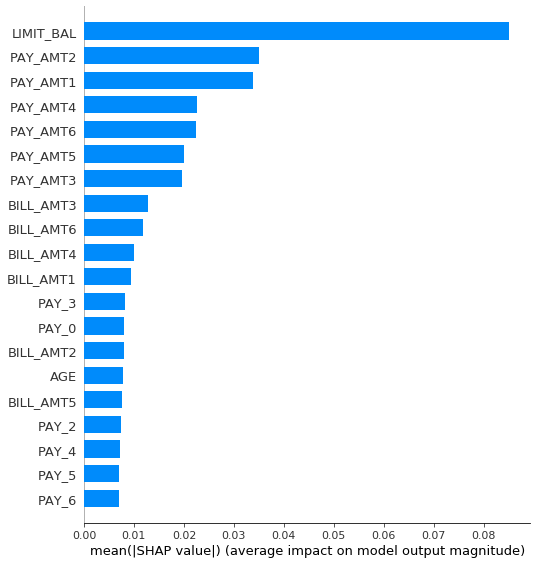

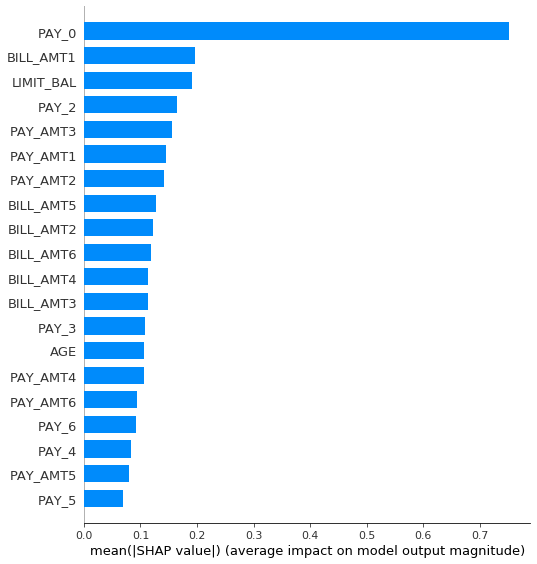

In [54]:
#Plot all the summary bar plots for SHAP for all models trained on segment 2

shap.summary_plot(rf_shap_values2[1], X_test_segment2, plot_type='bar')
shap.summary_plot(knn_shap_values2, X_test_segment2, plot_type='bar')
shap.summary_plot(gnb_shap_values2, X_test_segment2, plot_type='bar')
shap.summary_plot(xgb_shap_values2, X_test_segment2, plot_type='bar')